1. **Dataset Preparation**:  
   - Loading the **STL-10 dataset** and **MNIST dataset** using PyTorch's `Dataset` and `DataLoader`, I already downloaded the dataset from the website, then put that in the data folder.
   - Applying data transformations (normalization, resizing, data augmentation).


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class STL10Dataset(Dataset):
    def __init__(self, data_path, labels_path=None, transform=None):
        self.data_path = data_path
        self.labels_path = labels_path
        self.transform = transform
        self.data = self._read_images(data_path)

        if labels_path:
            self.labels = self._read_labels(labels_path)
        else:
            self.labels = None 

    def _read_images(self, file_path):
        with open(file_path, "rb") as f:
            images = np.fromfile(f, dtype=np.uint8)
        images = images.reshape(-1, 3, 96, 96) 
        return images

    def _read_labels(self, file_path):
        with open(file_path, "rb") as f:
            labels = np.fromfile(f, dtype=np.uint8)
        return labels - 1 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        image = np.transpose(image, (1, 2, 0)) 
        image = Image.fromarray(image) 

        if self.transform:
            image = self.transform(image)

        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image

stl10_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(96, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

stl10_train = STL10Dataset("data/stl10_binary/train_X.bin", "data/stl10_binary/train_y.bin", stl10_transforms)
stl10_test = STL10Dataset("data/stl10_binary/test_X.bin", "data/stl10_binary/test_y.bin", stl10_transforms)

stl10_train_loader = DataLoader(stl10_train, batch_size=64, shuffle=True, num_workers=4)
stl10_test_loader = DataLoader(stl10_test, batch_size=64, shuffle=False, num_workers=4)


In [ ]:
import torchvision.datasets as datasets

mnist_transforms = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),  
    transforms.Resize((96, 96)),                        
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mnist_train = datasets.MNIST(root="data/", train=True, download=False, transform=mnist_transforms)
mnist_test = datasets.MNIST(root="data/", train=False, download=False, transform=mnist_transforms)

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=4)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False, num_workers=4)


In [ ]:
stl10_batch = next(iter(stl10_train_loader))
mnist_batch = next(iter(mnist_train_loader))

print("STL-10 batch shape:", stl10_batch[0].shape)  
print("MNIST batch shape:", mnist_batch[0].shape)   


STL-10 batch shape: torch.Size([64, 3, 96, 96])
MNIST batch shape: torch.Size([64, 3, 96, 96])


2. **Model Training**:  
   - Initializing a **ResNet18** model pre-trained on ImageNet.
   - Training the model on the **STL-10 dataset**.
   - Evaluating model performance on the STL-10 test set.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(96, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.STL10(root="./data", split='train', download=True, transform=transform)
test_dataset = datasets.STL10(root="./data", split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 10) 
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

def train_model(model, train_loader, test_loader, num_epochs=25):
    best_acc = 0.0
    best_model_wts = None
    total_train_time = 0.0
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data).item()
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        epoch_time = time.time() - start_time
        total_train_time += epoch_time
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Time: {epoch_time:.2f}s")
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels.data).item()
                total += labels.size(0)
        
        test_acc = correct / total
        print(f"Test Accuracy: {test_acc:.4f}\n")
        
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = model.state_dict()
    
    print(f"Best Test Accuracy: {best_acc:.4f}")
    print(f"Total Training Time: {total_train_time:.2f}s")
    
    model.load_state_dict(best_model_wts)
    return model

trained_model = train_model(model, train_loader, test_loader, num_epochs=25)


Files already downloaded and verified
Files already downloaded and verified


Epoch 1/25: 100%|██████████| 79/79 [00:02<00:00, 27.62it/s]

Epoch 1/25 - Loss: 1.0399 Acc: 0.6448 Time: 2.86s


Test Accuracy: 0.6278



Epoch 2/25: 100%|██████████| 79/79 [00:02<00:00, 27.73it/s]

Epoch 2/25 - Loss: 0.6519 Acc: 0.7772 Time: 2.85s


Test Accuracy: 0.7676



Epoch 3/25: 100%|██████████| 79/79 [00:02<00:00, 27.60it/s]

Epoch 3/25 - Loss: 0.5164 Acc: 0.8194 Time: 2.87s


Test Accuracy: 0.6894



Epoch 4/25: 100%|██████████| 79/79 [00:02<00:00, 27.85it/s]

Epoch 4/25 - Loss: 0.5217 Acc: 0.8258 Time: 2.84s


Test Accuracy: 0.6809



Epoch 5/25: 100%|██████████| 79/79 [00:02<00:00, 27.84it/s]

Epoch 5/25 - Loss: 0.4388 Acc: 0.8480 Time: 2.84s


Test Accuracy: 0.7385



Epoch 6/25: 100%|██████████| 79/79 [00:02<00:00, 27.69it/s]

Epoch 6/25 - Loss: 0.4243 Acc: 0.8498 Time: 2.86s


Test Accuracy: 0.7680



Epoch 7/25: 100%|██████████| 79/79 [00:02<00:00, 27.66it/s]

Epoch 7/25 - Loss: 0.3675 Acc: 0.8726 Time: 2.86s


Test Accuracy: 0.7372



Epoch 8/25: 100%|██████████| 79/79 [00:02<00:00, 27.83it/s]

Epoch 8/25 - Loss: 0.3986 Acc: 0.8584 Time: 2.84s


Test Accuracy: 0.7715



Epoch 9/25: 100%|██████████| 79/79 [00:02<00:00, 27.64it/s]

Epoch 9/25 - Loss: 0.2817 Acc: 0.9076 Time: 2.86s


Test Accuracy: 0.7907



Epoch 10/25: 100%|██████████| 79/79 [00:02<00:00, 27.52it/s]

Epoch 10/25 - Loss: 0.3450 Acc: 0.8874 Time: 2.87s


Test Accuracy: 0.7859



Epoch 11/25: 100%|██████████| 79/79 [00:02<00:00, 27.72it/s]

Epoch 11/25 - Loss: 0.4086 Acc: 0.8598 Time: 2.85s


Test Accuracy: 0.7362



Epoch 12/25: 100%|██████████| 79/79 [00:02<00:00, 27.86it/s]

Epoch 12/25 - Loss: 0.4244 Acc: 0.8560 Time: 2.84s


Test Accuracy: 0.7973



Epoch 13/25: 100%|██████████| 79/79 [00:02<00:00, 28.00it/s]

Epoch 13/25 - Loss: 0.2867 Acc: 0.8994 Time: 2.83s


Test Accuracy: 0.8057



Epoch 14/25: 100%|██████████| 79/79 [00:02<00:00, 27.69it/s]

Epoch 14/25 - Loss: 0.1999 Acc: 0.9304 Time: 2.86s


Test Accuracy: 0.8070



Epoch 15/25: 100%|██████████| 79/79 [00:02<00:00, 27.62it/s]

Epoch 15/25 - Loss: 0.2417 Acc: 0.9172 Time: 2.87s


Test Accuracy: 0.7926



Epoch 16/25: 100%|██████████| 79/79 [00:02<00:00, 27.64it/s]

Epoch 16/25 - Loss: 0.2252 Acc: 0.9200 Time: 2.86s


Test Accuracy: 0.7809



Epoch 17/25: 100%|██████████| 79/79 [00:02<00:00, 27.59it/s]

Epoch 17/25 - Loss: 0.2622 Acc: 0.9074 Time: 2.87s


Test Accuracy: 0.8036



Epoch 18/25: 100%|██████████| 79/79 [00:02<00:00, 27.59it/s]

Epoch 18/25 - Loss: 0.1930 Acc: 0.9364 Time: 2.87s


Test Accuracy: 0.8099



Epoch 19/25: 100%|██████████| 79/79 [00:02<00:00, 27.70it/s]

Epoch 19/25 - Loss: 0.1354 Acc: 0.9554 Time: 2.86s


Test Accuracy: 0.7960



Epoch 20/25: 100%|██████████| 79/79 [00:02<00:00, 27.53it/s]

Epoch 20/25 - Loss: 0.1856 Acc: 0.9398 Time: 2.87s


Test Accuracy: 0.7857



Epoch 21/25: 100%|██████████| 79/79 [00:02<00:00, 27.66it/s]

Epoch 21/25 - Loss: 0.1675 Acc: 0.9442 Time: 2.86s


Test Accuracy: 0.7800



Epoch 22/25: 100%|██████████| 79/79 [00:02<00:00, 27.73it/s]

Epoch 22/25 - Loss: 0.1764 Acc: 0.9422 Time: 2.85s


Test Accuracy: 0.7877



Epoch 23/25: 100%|██████████| 79/79 [00:02<00:00, 27.71it/s]

Epoch 23/25 - Loss: 0.1655 Acc: 0.9464 Time: 2.85s


Test Accuracy: 0.7805



Epoch 24/25: 100%|██████████| 79/79 [00:02<00:00, 27.41it/s]

Epoch 24/25 - Loss: 0.1246 Acc: 0.9592 Time: 2.89s


Test Accuracy: 0.8054



Epoch 25/25: 100%|██████████| 79/79 [00:02<00:00, 27.61it/s]

Epoch 25/25 - Loss: 0.1408 Acc: 0.9512 Time: 2.87s


Test Accuracy: 0.7970

Best Test Accuracy: 0.8099
Total Training Time: 71.46s


3. **Transfer Learning**:  
   - Modifying the trained ResNet18 model for **transfer learning** with different strategies:
     - **Linear Transfer**: Freezing feature layers and retraining only the classifier.
     - **Partial Transfer**: Fine-tuning the later layers of the model while keeping early layers frozen.
     - **Full Transfer**: Training the entire model.


In [ ]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def modify_model_for_transfer(pretrained_model, strategy="linear"):
    
    model = copy.deepcopy(pretrained_model)
    
    if strategy == "linear":
        for param in model.features.parameters():
            param.requires_grad = False
        
        def reset_weights(m):
            if isinstance(m, nn.Linear):
                m.reset_parameters()
        model.classifier.apply(reset_weights)
        
    elif strategy == "partial":
        for idx, layer in enumerate(model.features):
            if idx < 4:
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                for param in layer.parameters():
                    param.requires_grad = True

        model.classifier.apply(lambda m: m.reset_parameters() if isinstance(m, nn.Linear) else None)
    
    elif strategy == "full":

        for param in model.parameters():
            param.requires_grad = True

    
    else:
        raise ValueError("Unknown strategy. Choose 'linear', 'partial', or 'full'.")
    
    return model

def train_transfer_model(model, train_loader, test_loader, num_epochs=10, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    
    best_acc = 0.0
    best_model_wts = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Transfer Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        

        model.eval()
        test_corrects = 0
        test_total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data)
                test_total += labels.size(0)
        test_acc = test_corrects.double() / test_total
        print(f"Test Accuracy: {test_acc:.4f}\n")
        
        if test_acc > best_acc:
            best_acc = test_acc
            best_model_wts = model.state_dict()
    
    print(f"Best Transfer Test Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_linear = modify_model_for_transfer(trained_model, strategy="linear")
print("Training with 'linear' transfer strategy...")
model_linear = train_transfer_model(model_linear, mnist_train_loader, mnist_test_loader, num_epochs=10, device=device)


model_partial = modify_model_for_transfer(trained_model, strategy="partial")
print("Training with 'partial' transfer strategy...")
model_partial = train_transfer_model(model_partial, mnist_train_loader, mnist_test_loader, num_epochs=10, device=device)


model_full = modify_model_for_transfer(trained_model, strategy="full")
print("Training with 'full' transfer strategy...")
model_full = train_transfer_model(model_full, mnist_train_loader, mnist_test_loader, num_epochs=10, device=device)


Training with 'linear' transfer strategy...


Transfer Epoch 1/10: 100%|██████████| 938/938 [00:19<00:00, 47.04it/s]

Epoch 1/10 - Loss: 0.4176 Acc: 0.8972


Test Accuracy: 0.9651



Transfer Epoch 2/10: 100%|██████████| 938/938 [00:19<00:00, 47.20it/s]

Epoch 2/10 - Loss: 0.2609 Acc: 0.9191


Test Accuracy: 0.9684



Transfer Epoch 3/10: 100%|██████████| 938/938 [00:19<00:00, 46.90it/s]

Epoch 3/10 - Loss: 0.2467 Acc: 0.9224


Test Accuracy: 0.9712



Transfer Epoch 4/10: 100%|██████████| 938/938 [00:19<00:00, 48.74it/s]

Epoch 4/10 - Loss: 0.2291 Acc: 0.9294


Test Accuracy: 0.9784



Transfer Epoch 5/10: 100%|██████████| 938/938 [00:19<00:00, 47.13it/s]

Epoch 5/10 - Loss: 0.2296 Acc: 0.9283


Test Accuracy: 0.9761



Transfer Epoch 6/10: 100%|██████████| 938/938 [00:19<00:00, 48.42it/s]

Epoch 6/10 - Loss: 0.2211 Acc: 0.9311


Test Accuracy: 0.9783



Transfer Epoch 7/10: 100%|██████████| 938/938 [00:19<00:00, 47.37it/s]

Epoch 7/10 - Loss: 0.2190 Acc: 0.9321


Test Accuracy: 0.9763



Transfer Epoch 8/10: 100%|██████████| 938/938 [00:20<00:00, 46.71it/s]

Epoch 8/10 - Loss: 0.2107 Acc: 0.9342


Test Accuracy: 0.9800



Transfer Epoch 9/10: 100%|██████████| 938/938 [00:19<00:00, 47.62it/s]

Epoch 9/10 - Loss: 0.2106 Acc: 0.9340


Test Accuracy: 0.9790



Transfer Epoch 10/10: 100%|██████████| 938/938 [00:19<00:00, 48.01it/s]

Epoch 10/10 - Loss: 0.2044 Acc: 0.9348


Test Accuracy: 0.9784

Best Transfer Test Accuracy: 0.9800
Training with 'partial' transfer strategy...


Transfer Epoch 1/10: 100%|██████████| 938/938 [00:29<00:00, 31.36it/s]

Epoch 1/10 - Loss: 0.3065 Acc: 0.9343


Test Accuracy: 0.9773



Transfer Epoch 2/10: 100%|██████████| 938/938 [00:29<00:00, 31.57it/s]

Epoch 2/10 - Loss: 0.0921 Acc: 0.9739


Test Accuracy: 0.9867



Transfer Epoch 3/10: 100%|██████████| 938/938 [00:30<00:00, 31.00it/s]

Epoch 3/10 - Loss: 0.0687 Acc: 0.9793


Test Accuracy: 0.9878



Transfer Epoch 4/10: 100%|██████████| 938/938 [00:29<00:00, 31.57it/s]

Epoch 4/10 - Loss: 0.0554 Acc: 0.9841


Test Accuracy: 0.9895



Transfer Epoch 5/10: 100%|██████████| 938/938 [00:29<00:00, 31.48it/s]

Epoch 5/10 - Loss: 0.0483 Acc: 0.9854


Test Accuracy: 0.9904



Transfer Epoch 6/10: 100%|██████████| 938/938 [00:30<00:00, 30.75it/s]

Epoch 6/10 - Loss: 0.0396 Acc: 0.9877


Test Accuracy: 0.9905



Transfer Epoch 7/10: 100%|██████████| 938/938 [00:30<00:00, 30.75it/s]

Epoch 7/10 - Loss: 0.0342 Acc: 0.9890


Test Accuracy: 0.9909



Transfer Epoch 8/10: 100%|██████████| 938/938 [00:30<00:00, 30.61it/s]

Epoch 8/10 - Loss: 0.0300 Acc: 0.9906


Test Accuracy: 0.9922



Transfer Epoch 9/10: 100%|██████████| 938/938 [00:29<00:00, 31.84it/s]

Epoch 9/10 - Loss: 0.0270 Acc: 0.9918


Test Accuracy: 0.9918



Transfer Epoch 10/10: 100%|██████████| 938/938 [00:30<00:00, 30.93it/s]

Epoch 10/10 - Loss: 0.0223 Acc: 0.9933


Test Accuracy: 0.9931

Best Transfer Test Accuracy: 0.9931
Training with 'full' transfer strategy...


Transfer Epoch 1/10: 100%|██████████| 938/938 [00:41<00:00, 22.82it/s]

Epoch 1/10 - Loss: 1.5023 Acc: 0.4176


Test Accuracy: 0.7966



Transfer Epoch 2/10: 100%|██████████| 938/938 [00:41<00:00, 22.78it/s]

Epoch 2/10 - Loss: 1.1592 Acc: 0.5573


Test Accuracy: 0.9609



Transfer Epoch 3/10: 100%|██████████| 938/938 [00:41<00:00, 22.51it/s]

Epoch 3/10 - Loss: 0.9745 Acc: 0.6374


Test Accuracy: 0.9712



Transfer Epoch 4/10: 100%|██████████| 938/938 [00:41<00:00, 22.75it/s]

Epoch 4/10 - Loss: 0.8464 Acc: 0.6850


Test Accuracy: 0.9743



Transfer Epoch 5/10: 100%|██████████| 938/938 [00:41<00:00, 22.83it/s]

Epoch 5/10 - Loss: 0.7323 Acc: 0.7116


Test Accuracy: 0.9771



Transfer Epoch 6/10: 100%|██████████| 938/938 [00:41<00:00, 22.70it/s]

Epoch 6/10 - Loss: 0.6898 Acc: 0.7249


Test Accuracy: 0.9786



Transfer Epoch 7/10: 100%|██████████| 938/938 [00:41<00:00, 22.76it/s]

Epoch 7/10 - Loss: 0.6290 Acc: 0.7548


Test Accuracy: 0.9816



Transfer Epoch 8/10: 100%|██████████| 938/938 [00:41<00:00, 22.60it/s]

Epoch 8/10 - Loss: 0.5731 Acc: 0.7775


Test Accuracy: 0.9814



Transfer Epoch 9/10: 100%|██████████| 938/938 [00:41<00:00, 22.68it/s]

Epoch 9/10 - Loss: 0.5351 Acc: 0.7921


Test Accuracy: 0.9857



Transfer Epoch 10/10: 100%|██████████| 938/938 [00:41<00:00, 22.57it/s]

Epoch 10/10 - Loss: 0.4875 Acc: 0.8204


Test Accuracy: 0.9832

Best Transfer Test Accuracy: 0.9857


4. **Evaluation and Visualization**:  
   - Evaluating the **transfer learning performance** on MNIST.
   - Generating a **classification report** and a **confusion matrix**.


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



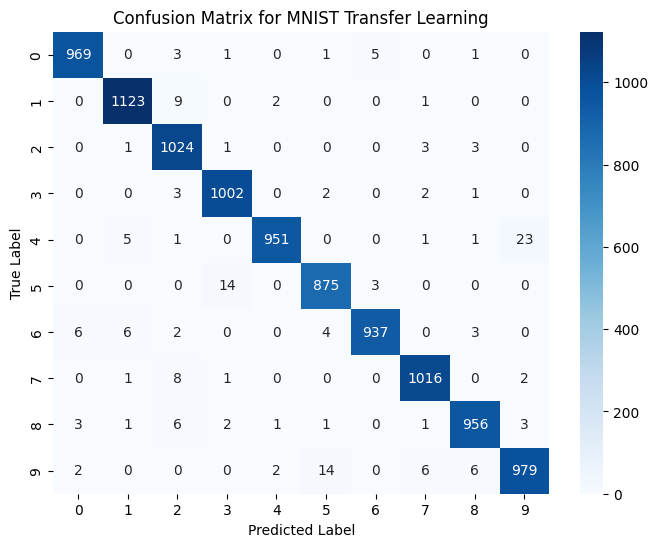

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    
    
    model = model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds


true_labels, predictions = evaluate_model(model_full, mnist_test_loader, device)


print("Classification Report:")
mnist_classes = [str(i) for i in range(10)]

print(classification_report(true_labels, predictions, target_names=mnist_classes))


cm = confusion_matrix(true_labels, predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=mnist_classes,
            yticklabels=mnist_classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for MNIST Transfer Learning")
plt.show()
